In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import model_selection

In [2]:
# load dataset from from sklearn
from sklearn.datasets import load_digits
digits = load_digits()
print(digits.keys())
print(type(digits.data))
print(type(digits.images))
print(digits.images.shape)

dict_keys(['data', 'target', 'target_names', 'images', 'DESCR'])
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
(1797, 8, 8)


In [3]:
# define color
yellow = 1
green = 0.7

# 3. Data Preparation

In [4]:
def select_by_y(X, Y, selection):
    """
    select instances whose y is in selection
    Args:
        X: feature set
        Y: response(target) set
        selection: list of target value
    """
    N = len(X)
    new_X = []
    new_Y = []
    for i in range(N):
        if Y[i] in selection:
            new_X.append(X[i])
            new_Y.append(Y[i])
    return np.asarray(new_X),np.asarray(new_Y)

# select instances whose target are "1" and "7"
X_all, Y_all = select_by_y(digits.data, digits.target, [1, 7])
print("the numebr of instances is", len(X_all))

# split data set into training data and test data
X_train, X_test, Y_train, Y_test = model_selection.train_test_split(X_all, Y_all, test_size=0.4, random_state=0)
print("number of instances in traning data:", len(X_train))
print("number of instances in test data:", len(X_test))

the numebr of instances is 361
number of instances in traning data: 216
number of instances in test data: 145


## 3.1 Dimension Reduction
* choose two pixels that seem to have a big influence
* come up with some clever combination of the 64 original pixel values into 2 features

In [5]:
X_train_1, _ = select_by_y(X_train, Y_train, [1])
X_train_7, _ = select_by_y(X_train, Y_train, [7])

# calculate the mean of all instances of 1 and 7 respectively
mean_1 = np.mean(X_train_1, axis=0)
mean_7 = np.mean(X_train_7, axis=0)

# mean_1_image = mean_1.reshape((8,8))
# mean_7_image = mean_7.reshape((8,8))
# def show_image(image):
#     plt.figure()
#     plt.gray()
#     plt.imshow(image, interpolation="nearest")
#     plt.show()
# show_image(mean_1_image)
# show_image(mean_7_image)

# select the most influential K dimensions
def topK_important_dimension(mean_a, mean_b, K):
    N = len(mean_a)
    assert K<=N
    return np.argsort(np.absolute(np.subtract(mean_a, mean_b)))[N-K:]

dims = topK_important_dimension(mean_1, mean_7, 2)

def reduce_dim(X):
    N = len(X)
    return X[:,dims] # take the most 2 important dimensions

X_train = reduce_dim(X_train)
X_test = reduce_dim(X_test)
X_train_1 = reduce_dim(X_train_1)
X_train_7 = reduce_dim(X_train_7)
#print(X_train)


## 3.2 Scatterplot

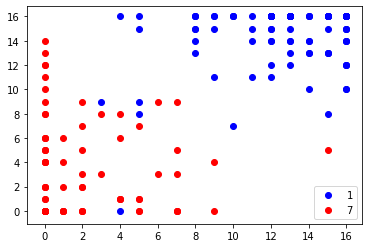

In [6]:
plt.scatter(X_train_1[:,0].transpose(), X_train_1[:,1].transpose(), c='r', label="1")
plt.scatter(X_train_7[:,0].transpose(), X_train_7[:,1].transpose(), c='b', label="7")
plt.legend()
plt.show()

# 4. Nearest Mean

## 4.1 Implement the nearest mean classifier

In [7]:
def dist_vec(training, test):
    """
    calculate the distance matrix using vectorization method
    """
    training_square = np.sum(training*training, axis=1, keepdims=True)
    test_square = np.sum(test*test, axis=1, keepdims=True).T
    distances = np.dot(training, test.T)
    distances *= -2
    distances += training_square
    distances += test_square
    np.maximum(distances, 0, distances)
    np.sqrt(distances, distances)
    return distances

def nearest_mean(training_features, training_labels, test_features):
    """
    predict by nearest mean
    """
    train_1, _ = select_by_y(training_features, training_labels, [1]) # training features whose label is 1
    train_7, _ = select_by_y(training_features, training_labels, [7]) # training features whose label is 7
    mean_1 = np.mean(train_1, axis=0)
    mean_7 = np.mean(train_7, axis=0)
    mean_matrix = np.vstack((mean_1, mean_7))
    distance_matrix = dist_vec(mean_matrix, test_features) # distance matrix: 2*M (M is the number of instances in test set)
    sorted_distance_indices = np.argsort(distance_matrix, axis=0)
    nearest_indices = sorted_distance_indices[0,:]
    return np.asarray([1,7]).take(nearest_indices)

def cal_err(Y_test, Y_pred):
    """calculate the error rate"""
    return np.sum((Y_test - Y_pred)!=0)/Y_pred.size
    
Y_pred = nearest_mean(X_train, Y_train, X_test)
print(cal_err(Y_test, Y_pred))
    
# a = np.asarray([1,7])
# print(a.take([0,1,1,1,1]))

0.006896551724137931


## 4.2 Visualize the decision regions

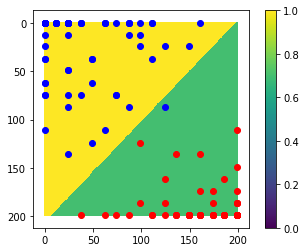

In [8]:
mean_1 = np.mean(X_train_1, axis=0)
mean_7 = np.mean(X_train_7, axis=0)
def predict(X): # X: 1*2 vector
    distance_1 = np.sqrt(np.sum(np.subtract(X, mean_1)**2))
    distance_7 = np.sqrt(np.sum(np.subtract(X, mean_7)**2))
    if distance_1 < distance_7:
        return 1
    else:
        return 7

def decision_region():
    image = np.zeros((200, 200))
    step = 16 / (200-1)
    for i in range(200):
        for j in range(200):
            x0 = i*step
            x1 = j*step
            if predict([x0,x1]) == 1:
                image[i][j] = green
            else :
                image[i][j] = yellow
    return image


X_test_draw_1, _ = select_by_y((X_test*199/16).astype(int), Y_test, [1])
X_test_draw_7, _ = select_by_y((X_test*199/16).astype(int), Y_test, [7])

plt.figure()
plt.imshow(decision_region(), vmin=0, vmax=1)
plt.scatter(X_test_draw_1[:,0].transpose(), X_test_draw_1[:,1].transpose(), c="r")
plt.scatter(X_test_draw_7[:,0].transpose(), X_test_draw_7[:,1].transpose(), c="b")
plt.colorbar() 
plt.show()
  
    

# QDA
## 5.1 Implement QDA Training

$$\hat{\mu}_k = \frac{1}{N_k}\Sigma_{i:y_i=k}x_i$$
$$\hat{\Sigma_k} = \frac{1}{N_k}\Sigma_{i:y_i=k}(x_i-\mu_k)^T(x_i-\mu_k)$$
$x_i$ is the i th instance

In [15]:
def fit_qda(training_features, training_labels):
    D = training_features.shape[1]  # dimensions of training data
    X_0, _ = select_by_y(training_features, training_labels, [1])
    X_1, _ = select_by_y(training_features, training_labels, [7])
    mu = np.vstack((np.mean(X_0, axis=0), np.mean(X_1, axis=0)))
    covmat = np.zeros((2,D,D))
    for i in range(len(X_0)):
        covmat[0] += 1/len(X_0)* np.mat(X_0[i]-mu[0]).T * np.mat(X_0[i]-mu[0])
    for i in range(len(X_1)):
        covmat[1] += 1/len(X_1)* np.mat(X_1[i]-mu[1]).T * np.mat(X_1[i]-mu[1])
    prior = [len(X_0)/len(training_features), len(X_1)/len(training_features)]
    return mu, covmat, prior


calculate $\mu, \Sigma$ and priors

In [16]:
mu, covmat, p = fit_qda(X_train, Y_train)

## 5.2 Implement QDA Prediction

In [17]:
def predict_qda(mu, covmat, p, test_features):
    M = len(test_features)
    b_0 = (1/2)*np.log(np.linalg.det(2*np.pi*covmat[0])) - np.log(p[0])
    b_1 = (1/2)*np.log(np.linalg.det(2*np.pi*covmat[1])) - np.log(p[1])
    likelihoods = np.zeros((2, M))
    for i in range(M):
        likelihoods[0][i] = (1/2)*np.mat(test_features[i]-mu[0])*np.linalg.inv(covmat[0])*np.mat(test_features[i]-mu[0]).T + b_0
        likelihoods[1][i] = (1/2)*np.mat(test_features[i]-mu[1])*np.linalg.inv(covmat[1])*np.mat(test_features[i]-mu[1]).T + b_1
    sorted_indices = np.argsort(likelihoods, axis=0)
    return sorted_indices[0, :]


# make prediction
indices5 = predict_qda(mu, covmat, p, X_test)
Y_pred5 = np.asarray([1,7]).take(indices5)  # map 0,1 in predictions to real response value "1" and "7"
print("error rate of test set:",cal_err(Y_pred5, Y_test))

        

error rate of test set: 0.006896551724137931


## 5.3 Visualization

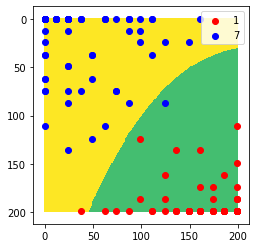

In [44]:
N_image = 200
image = np.zeros((N_image, N_image))
step = 16 / (N_image-1)
for i in range(N_image):
    for j in range(N_image):
        x0 = i*step
        x1 = j*step
        if predict_qda(mu, covmat, p, [[x0,x1]]) == 0:
            image[i][j] = green
        else :
            image[i][j] = yellow


X_test_draw_1, _ = select_by_y((X_test*(1/step)).astype(int), Y_test, [1])
X_test_draw_7, _ = select_by_y((X_test*(1/step)).astype(int), Y_test, [7])

plt.figure()
plt.imshow(image, vmin=0, vmax=1)
plt.scatter(X_test_draw_1[:,0].transpose(), X_test_draw_1[:,1].transpose(), c="r", label="1")
plt.scatter(X_test_draw_7[:,0].transpose(), X_test_draw_7[:,1].transpose(), c="b", label="7")
plt.legend()
plt.show()

# 6 LDA
$$\Sigma_w = \frac{1}{N}\Sigma_{i=1}^{N}(x_i-\mu_{y_i})^T(x_i-\mu_{y_i})$$

In [46]:
def fit_lda(training_features, training_labels):
    D = training_features.shape[1]  # dimensions of training data
    X_0, _ = select_by_y(training_features, training_labels, [1])
    X_1, _ = select_by_y(training_features, training_labels, [7])
    mu = np.vstack((np.mean(X_0, axis=0), np.mean(X_1, axis=0)))
    covmat = np.zeros((D,D))
    for i in range(len(X_0)):
        covmat += 1/len(X_0)* np.mat(X_0[i]-mu[0]).T * np.mat(X_0[i]-mu[0])
    for i in range(len(X_1)):
        covmat += 1/len(X_1)* np.mat(X_1[i]-mu[1]).T * np.mat(X_1[i]-mu[1])
    prior = [len(X_0)/len(training_features), len(X_1)/len(training_features)]
    return mu, covmat, prior
    
def predict_lda(mu, covmat, prior, test_features):
    b_0 = (1/2)*np.log(np.linalg.det(2*np.pi*covmat)) - np.log(p[0])
    b_1 = (1/2)*np.log(np.linalg.det(2*np.pi*covmat)) - np.log(p[1])
    b_0 += (1/2)*np.mat(mu[0])*np.mat(covmat)*np.mat(mu[0]).T
    b_1 += (1/2)*np.mat(mu[1])*np.mat(covmat)*np.mat(mu[1]).T
    b = b_0 - b_1
    W = np.mat(mu[1]-mu[0])*np.mat(covmat)
    predicted = np.mat(W)*np.mat(test_features).T + b
    predicted = predicted>0
    predicted = predicted + 0
    return predicted
    
mu, covmat, p = fit_lda(X_train, Y_train)
indices6 = predict_lda(mu, covmat, p, X_test)
Y_pred6 = np.asarray([1,7]).take(indices6)
print(cal_err(Y_pred6, Y_test))


0.006896551724137931


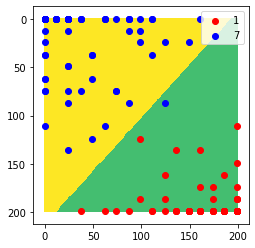

In [47]:
N_image = 200
image = np.zeros((N_image, N_image))
step = 16 / (N_image-1)
for i in range(N_image):
    for j in range(N_image):
        x0 = i*step
        x1 = j*step
        if predict_lda(mu, covmat, p, [[x0,x1]]) == 0:
            image[i][j] = green
        else :
            image[i][j] = yellow


X_test_draw_1, _ = select_by_y((X_test*(1/step)).astype(int), Y_test, [1])
X_test_draw_7, _ = select_by_y((X_test*(1/step)).astype(int), Y_test, [7])

plt.figure()
plt.imshow(image, vmin=0, vmax=1)
plt.scatter(X_test_draw_1[:,0].transpose(), X_test_draw_1[:,1].transpose(), c="r", label="1")
plt.scatter(X_test_draw_7[:,0].transpose(), X_test_draw_7[:,1].transpose(), c="b", label="7")
plt.legend()
plt.show()